Found 2301 images belonging to 4 classes.
Found 1737 images belonging to 4 classes.
Found 1736 images belonging to 4 classes.
Class Names: ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4523 - loss: 1.2814 
Epoch 1: val_accuracy improved from -inf to 0.55498, saving model to /kaggle/working/best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 222ms/step - accuracy: 0.4527 - loss: 1.2802 - val_accuracy: 0.5550 - val_loss: 1.0234
Epoch 2/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6482 - loss: 0.8382
Epoch 2: val_accuracy improved from 0.55498 to 0.57225, saving model to /kaggle/working/best_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6487 - loss: 0.8374 - val_accuracy: 0.5723 - val_loss: 0.9819
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7676 - loss: 0.6156
Epoch 3: val_accuracy did not improve from 0.57225
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.7676 - loss: 0.6156 - val_accuracy: 0.5699 - val_loss: 1.0025
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8479 - loss: 0.4673
Epoch 4: val_accuracy did not improve from 0.57225
72/72 ━━━━━

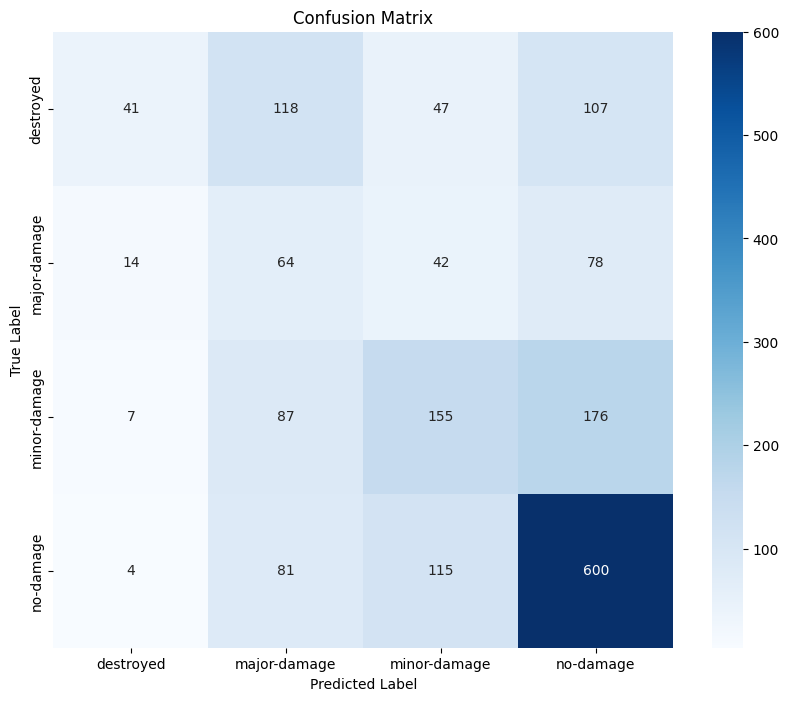

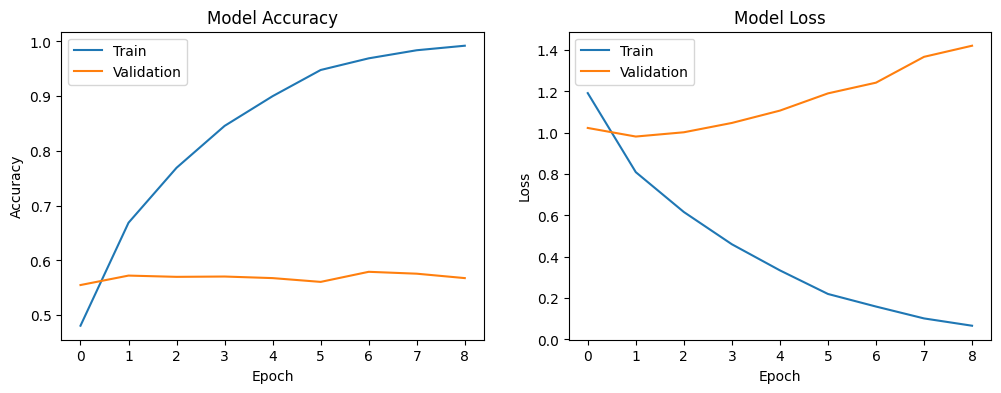

In [17]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Preprocess the Data
base_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Only rescaling, no augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# 2. Model Setup
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze most layers and fine-tune only top layers
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model
epochs = 50

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Found 2301 images belonging to 4 classes.
Found 1737 images belonging to 4 classes.
Found 1736 images belonging to 4 classes.
Class Names: ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.3796 - loss: 1.3421
Epoch 1: val_accuracy improved from -inf to 0.53253, saving model to /kaggle/working/best_model_augmented.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 49s 453ms/step - accuracy: 0.3807 - loss: 1.3396 - val_accuracy: 0.5325 - val_loss: 1.0879
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4641 - loss: 1.1528
Epoch 2: val_accuracy improved from 0.53253 to 0.55210, saving model to /kaggle/working/best_model_augmented.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.4642 - loss: 1.1525 - val_accuracy: 0.5521 - val_loss: 1.0458
Epoch 3/100
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.5083 - loss: 1.0803
Epoch 3: val_accuracy improved from 0.55210 to 0.55440, saving model to /kaggle/working/best_model_augmented.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 354ms/step - accuracy: 0.5082 - loss: 1.0803 - val_accuracy: 0.5544 - val_loss: 1.0391
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - 

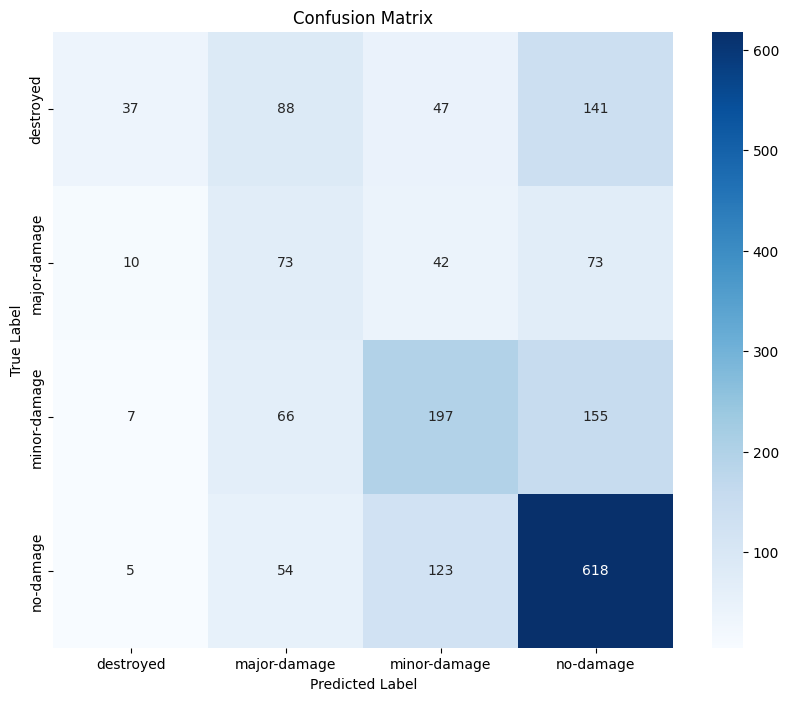

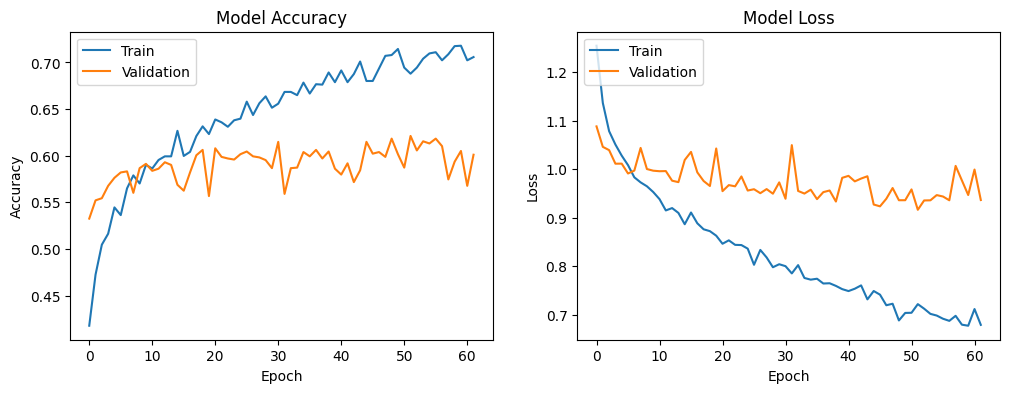

In [18]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and Preprocess the Data
base_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# 2. Model Setup
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze most layers and fine-tune only top layers
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=5e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10, # Increased patience due to more epochs
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_augmented.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model with more epochs
epochs = 100

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_augmented.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Found 2301 images belonging to 4 classes.
Found 1737 images belonging to 4 classes.
Found 1736 images belonging to 4 classes.
Class Names: ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
Class Weights: {0: 7.67, 1: 1.1551204819277108, 2: 0.9308252427184466, 3: 0.5182432432432432}
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.3410 - loss: 1.6580
Epoch 1: val_accuracy improved from -inf to 0.36615, saving model to /kaggle/working/best_model_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 482ms/step - accuracy: 0.3410 - loss: 1.6571 - val_accuracy: 0.3661 - val_loss: 1.3624
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.3276 - loss: 1.4941
Epoch 2: val_accuracy improved from 0.36615 to 0.40818, saving model to /kaggle/working/best_model_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 354ms/step - accuracy: 0.3276 - loss: 1.4939 - val_accuracy: 0.4082 - val_loss: 1.3110
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3188 - loss: 1.4049
Epoch 3: val_accuracy improved from 0.40818 to 0.41451, saving model to /kaggle/working/best_model_finetuned.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - accuracy: 0.3189 - loss: 1.4051 - val_accuracy: 0.4145 - val_loss: 1.2810
Epoch 4/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - 

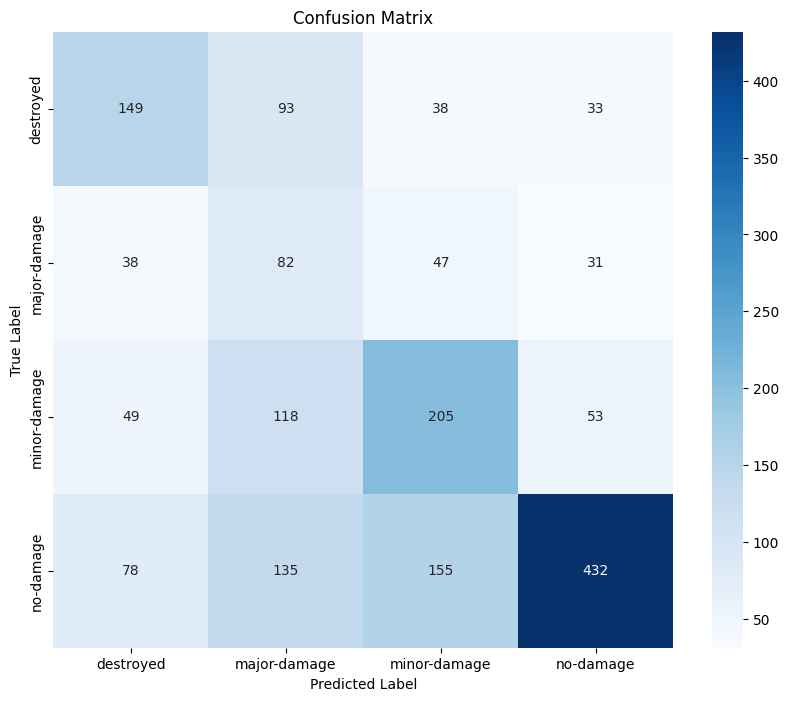

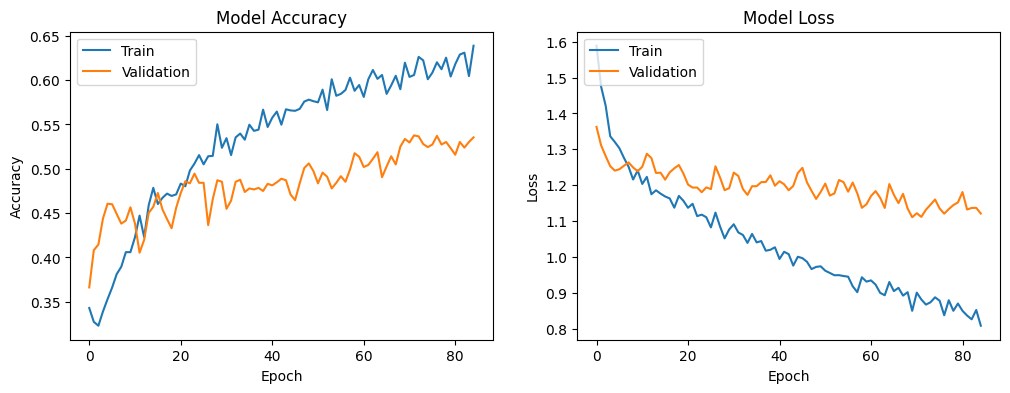

In [19]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data
base_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Calculate Class Weights
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights:", class_weights_dict)

# 2. Model Setup - Unfreeze more layers
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Unfreeze the last 20 layers (experiment with this number)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model with a very low learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # Even lower learning rate for more fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Increased patience again
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model with class weights
epochs = 150 # Increased epochs again
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights_dict # Pass the class weights here
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_finetuned.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Found 2301 images belonging to 4 classes.
Found 1737 images belonging to 4 classes.
Found 1736 images belonging to 4 classes.
Class Names: ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
Class Weights: {0: 7.67, 1: 1.1551204819277108, 2: 0.9308252427184466, 3: 0.5182432432432432}
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.2872 - loss: 1.5533
Epoch 1: val_accuracy improved from -inf to 0.43811, saving model to /kaggle/working/best_model_finetuned_lr_adjusted.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 477ms/step - accuracy: 0.2873 - loss: 1.5526 - val_accuracy: 0.4381 - val_loss: 1.2084
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3154 - loss: 1.4242
Epoch 2: val_accuracy did not improve from 0.43811
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 338ms/step - accuracy: 0.3155 - loss: 1.4240 - val_accuracy: 0.4329 - val_loss: 1.2118
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3531 - loss: 1.3170
Epoch 3: val_accuracy improved from 0.43811 to 0.43926, saving model to /kaggle/working/best_model_finetuned_lr_adjusted.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 348ms/step - accuracy: 0.3532 - loss: 1.3169 - val_accuracy: 0.4393 - val_loss: 1.2228
Epoch 4/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3688 - loss: 1.2940
Epoch 4:

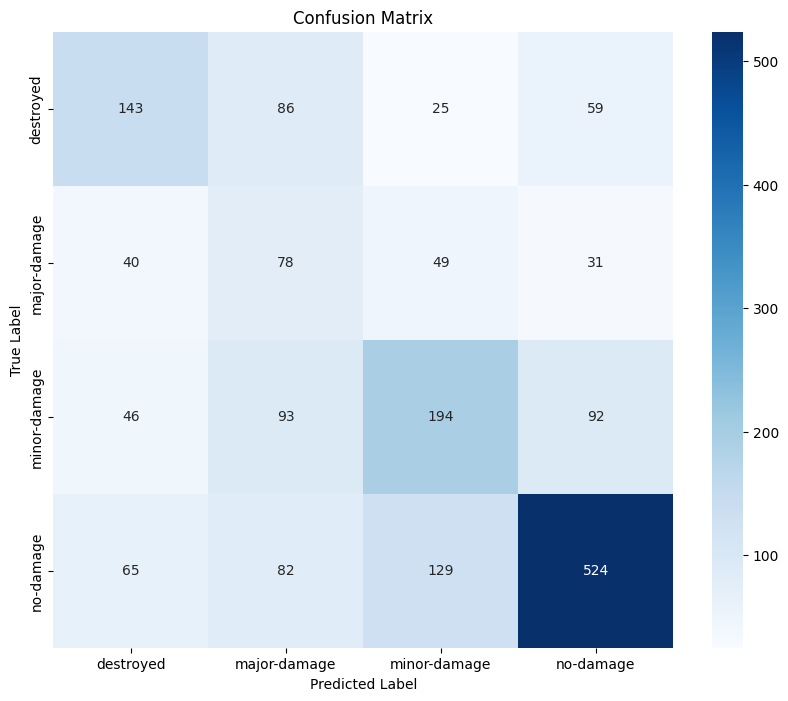

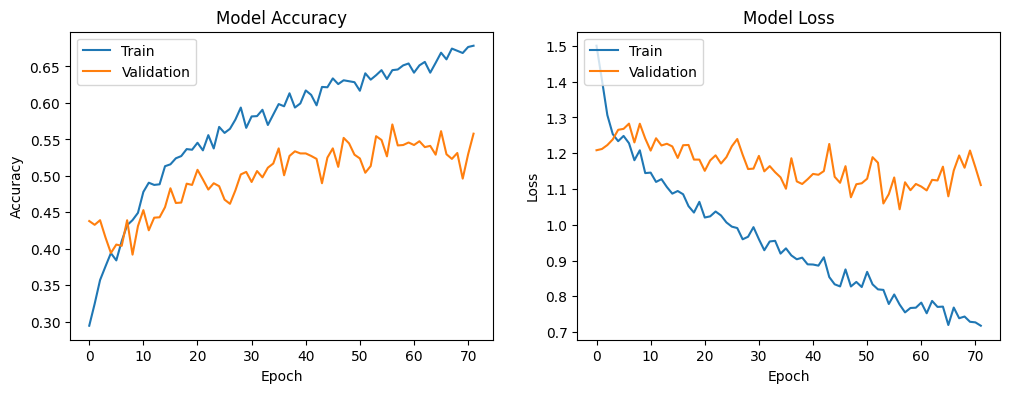

In [20]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data
base_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Calculate Class Weights
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights:", class_weights_dict)

# 2. Model Setup - Unfreeze the last 20 layers
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model with the adjusted learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5), # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_finetuned_lr_adjusted.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model with class weights
epochs = 150
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights_dict
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_finetuned_lr_adjusted.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


2025-04-27 04:50:35.674055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745729435.876323      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745729435.938513      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2301 images belonging to 4 classes.
Found 1737 images belonging to 4 classes.
Found 1736 images belonging to 4 classes.
Class Names: ['destroyed', 'major-damage', 'minor-damage', 'no-damage']
Class Weights: {0: 7.67, 1: 1.1551204819277108, 2: 0.9308252427184466, 3: 0.5182432432432432}


I0000 00:00:1745729454.990337      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745729477.644803      96 service.cc:148] XLA service 0x7e3924003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745729477.646058      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745729479.129749      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/72 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.1094 - loss: 1.6575  

I0000 00:00:1745729485.965673      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2184 - loss: 1.5629
Epoch 1: val_accuracy improved from -inf to 0.34312, saving model to /kaggle/working/best_model_finetuned_lr_1_5e-5.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 71s 664ms/step - accuracy: 0.2190 - loss: 1.5620 - val_accuracy: 0.3431 - val_loss: 1.3286
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3138 - loss: 1.4037
Epoch 2: val_accuracy improved from 0.34312 to 0.41854, saving model to /kaggle/working/best_model_finetuned_lr_1_5e-5.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 29s 374ms/step - accuracy: 0.3137 - loss: 1.4034 - val_accuracy: 0.4185 - val_loss: 1.2341
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3304 - loss: 1.2557
Epoch 3: val_accuracy did not improve from 0.41854
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.3305 - loss: 1.2568 - val_accuracy: 0.4168 - val_loss: 1.2193
Epoch 4/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3493 - loss: 1.3389
Epoch 4: val

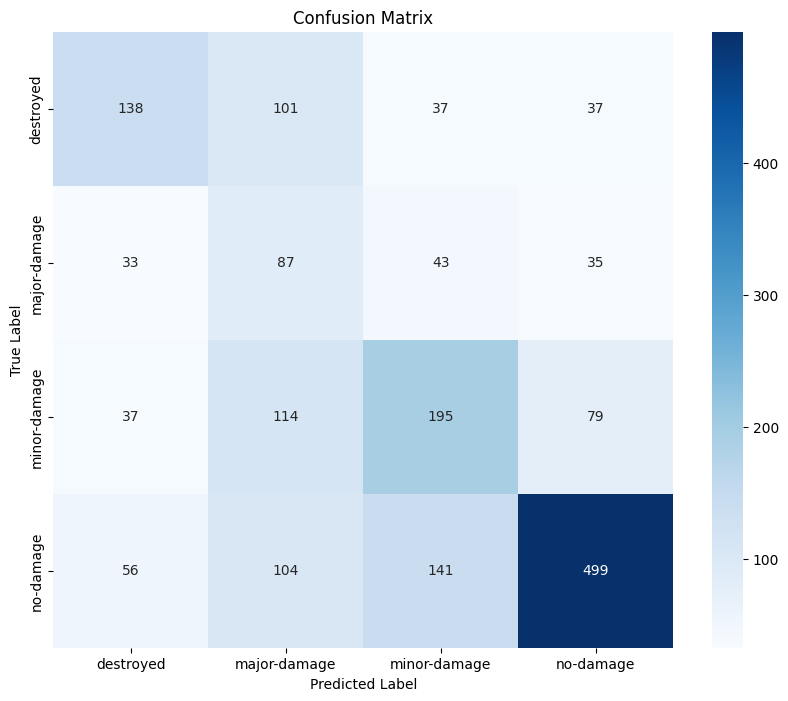

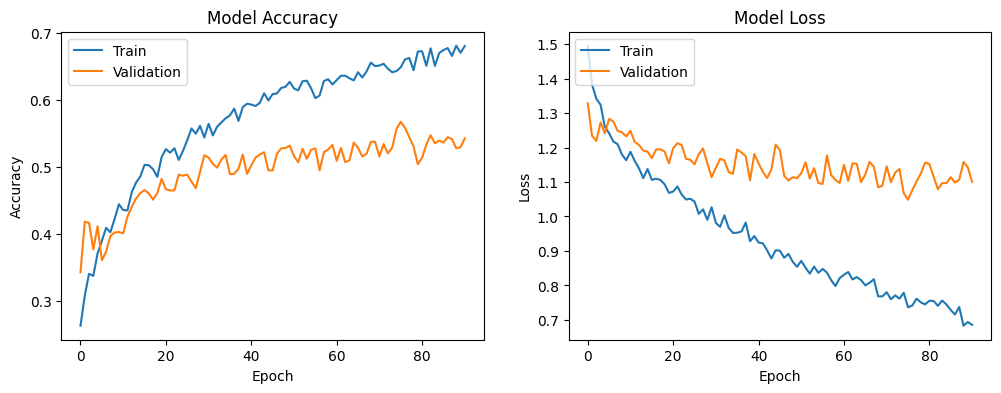

In [1]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data
base_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Calculate Class Weights
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights:", class_weights_dict)

# 2. Model Setup - Unfreeze the last 20 layers
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model with the adjusted learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1.5e-5), # Adjusted learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_finetuned_lr_1_5e-5.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model with class weights
epochs = 150
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights_dict
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_finetuned_lr_1_5e-5.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and report
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [2]:
#Trying the 3 class Appraoch

In [8]:
import os
import shutil

base_input_dir = '/kaggle/input/combinedfrsh/xbd_combined_data'
base_working_dir = '/kaggle/working/xbd_reorganized'

train_input_dir = os.path.join(base_input_dir, 'train')
val_input_dir = os.path.join(base_input_dir, 'val')
test_input_dir = os.path.join(base_input_dir, 'test')

train_working_dir = os.path.join(base_working_dir, 'train')
val_working_dir = os.path.join(base_working_dir, 'val')
test_working_dir = os.path.join(base_working_dir, 'test')

# Create the base working directory (exist_ok=True in case it's already there)
os.makedirs(base_working_dir, exist_ok=True)

# Remove existing working directories to ensure a clean copy
if os.path.exists(train_working_dir):
    shutil.rmtree(train_working_dir)
if os.path.exists(val_working_dir):
    shutil.rmtree(val_working_dir)
if os.path.exists(test_working_dir):
    shutil.rmtree(test_working_dir)

# Copy train, val, and test directories
shutil.copytree(train_input_dir, train_working_dir)
shutil.copytree(val_input_dir, val_working_dir)
shutil.copytree(test_input_dir, test_working_dir)

print("Data re-copied to /kaggle/working/")

Data re-copied to /kaggle/working/


In [9]:
import os
import shutil

base_working_dir = '/kaggle/working/xbd_reorganized'
train_working_dir = os.path.join(base_working_dir, 'train')
val_working_dir = os.path.join(base_working_dir, 'val')
test_working_dir = os.path.join(base_working_dir, 'test')

# Create the new 'severe-damage' directories
os.makedirs(os.path.join(train_working_dir, 'severe-damage'), exist_ok=True)
os.makedirs(os.path.join(val_working_dir, 'severe-damage'), exist_ok=True)
os.makedirs(os.path.join(test_working_dir, 'severe-damage'), exist_ok=True)

# Move files in train
destroyed_train_dir = os.path.join(train_working_dir, 'destroyed')
major_damage_train_dir = os.path.join(train_working_dir, 'major-damage')

if os.path.exists(destroyed_train_dir):
    for filename in os.listdir(destroyed_train_dir):
        source = os.path.join(destroyed_train_dir, filename)
        destination = os.path.join(os.path.join(train_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(destroyed_train_dir) and not os.listdir(destroyed_train_dir):
        os.rmdir(destroyed_train_dir)

if os.path.exists(major_damage_train_dir):
    for filename in os.listdir(major_damage_train_dir):
        source = os.path.join(major_damage_train_dir, filename)
        destination = os.path.join(os.path.join(train_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(major_damage_train_dir) and not os.listdir(major_damage_train_dir):
        os.rmdir(major_damage_train_dir)

# Move files in val
destroyed_val_dir = os.path.join(val_working_dir, 'destroyed')
major_damage_val_dir = os.path.join(val_working_dir, 'major-damage')

if os.path.exists(destroyed_val_dir):
    for filename in os.listdir(destroyed_val_dir):
        source = os.path.join(destroyed_val_dir, filename)
        destination = os.path.join(os.path.join(val_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(destroyed_val_dir) and not os.listdir(destroyed_val_dir):
        os.rmdir(destroyed_val_dir)

if os.path.exists(major_damage_val_dir):
    for filename in os.listdir(major_damage_val_dir):
        source = os.path.join(major_damage_val_dir, filename)
        destination = os.path.join(os.path.join(val_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(major_damage_val_dir) and not os.listdir(major_damage_val_dir):
        os.rmdir(major_damage_val_dir)

# Move files in test
destroyed_test_dir = os.path.join(test_working_dir, 'destroyed')
major_damage_test_dir = os.path.join(test_working_dir, 'major-damage')

if os.path.exists(destroyed_test_dir):
    for filename in os.listdir(destroyed_test_dir):
        source = os.path.join(destroyed_test_dir, filename)
        destination = os.path.join(os.path.join(test_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(destroyed_test_dir) and not os.listdir(destroyed_test_dir):
        os.rmdir(destroyed_test_dir)

if os.path.exists(major_damage_test_dir):
    for filename in os.listdir(major_damage_test_dir):
        source = os.path.join(major_damage_test_dir, filename)
        destination = os.path.join(os.path.join(test_working_dir, 'severe-damage'), filename)
        shutil.move(source, destination)
    if os.path.exists(major_damage_test_dir) and not os.listdir(major_damage_test_dir):
        os.rmdir(major_damage_test_dir)

print("Data re-organized in /kaggle/working/ complete!")

Data re-organized in /kaggle/working/ complete!


In [10]:
import os

working_base_dir = '/kaggle/working/xbd_reorganized'
train_dir = os.path.join(working_base_dir, 'train')
val_dir = os.path.join(working_base_dir, 'val')
test_dir = os.path.join(working_base_dir, 'test')

print("Contents of training directory:")
print(os.listdir(train_dir))

print("\nContents of validation directory:")
print(os.listdir(val_dir))

print("\nContents of testing directory:")
print(os.listdir(test_dir))

Contents of training directory:
['minor-damage', 'severe-damage', 'no-damage']

Contents of validation directory:
['minor-damage', 'severe-damage', 'no-damage']

Contents of testing directory:
['minor-damage', 'severe-damage', 'no-damage']


Found 2301 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.
Found 1736 images belonging to 3 classes.
Class Names (3 classes): ['minor-damage', 'no-damage', 'severe-damage']
Class Weights (3 classes): {0: 1.2411003236245954, 1: 0.690990990990991, 2: 1.3385689354275743}
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.3229 - loss: 1.2605
Epoch 1: val_accuracy improved from -inf to 0.35291, saving model to /kaggle/working/best_model_3class_finetuned_unfreeze25.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 461ms/step - accuracy: 0.3235 - loss: 1.2599 - val_accuracy: 0.3529 - val_loss: 1.1792
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4129 - loss: 1.1343
Epoch 2: val_accuracy improved from 0.35291 to 0.40818, saving model to /kaggle/working/best_model_3class_finetuned_unfreeze25.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 337ms/step - accuracy: 0.4130 - loss: 1.1342 - val_accuracy: 0.4082 - val_loss: 1.0871
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4258 - loss: 1.0691
Epoch 3: val_accuracy improved from 0.40818 to 0.50374, saving model to /kaggle/working/best_model_3class_finetuned_unfreeze25.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.4261 - loss: 1.0690 - val_accuracy: 0.5037 - val_loss: 0.9872
E

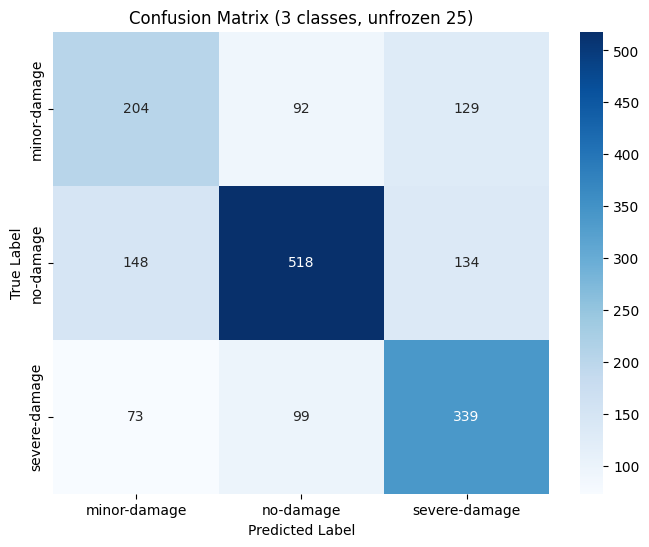

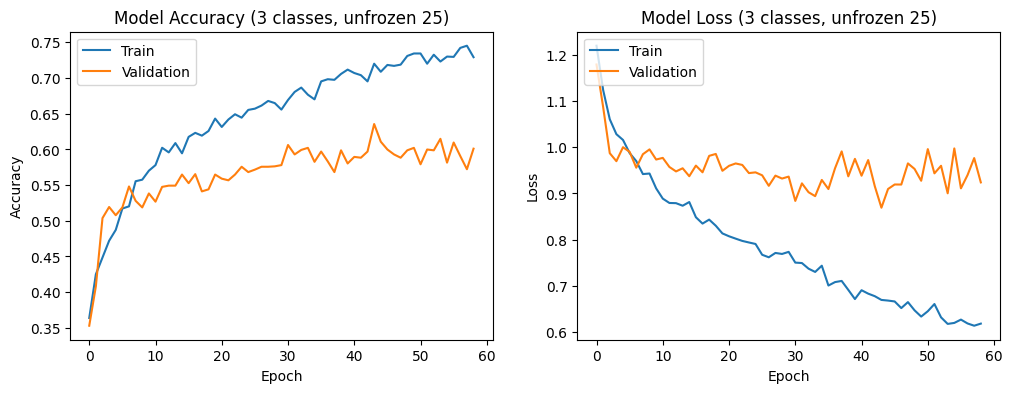

In [15]:
# Imports (same as before)
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data (Adjusted for 3 classes and new directory)
base_dir = '/kaggle/working/xbd_reorganized'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names (3 classes):", class_names)

# Calculate Class Weights (for 3 classes)
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights (3 classes):", class_weights_dict)

# 2. Model Setup - Unfreeze the last 25 layers of ResNet50V2
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-25]: # Unfreeze the last 25 layers
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax') # Output layer with 3 units
])

# 3. Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5), # Using the best learning rate found so far
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_3class_finetuned_unfreeze25.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# 5. Train the Model
epochs = 150
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1,
    class_weight=class_weights_dict
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_3class_finetuned_unfreeze25.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss (3 classes, unfrozen 25): {test_loss:.4f}, Test Accuracy (3 classes, unfrozen 25): {test_accuracy:.4f}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report (3 classes, unfrozen 25):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (3 classes, unfrozen 25)')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (3 classes, unfrozen 25)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (3 classes, unfrozen 25)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Found 2301 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.
Found 1736 images belonging to 3 classes.
Class Names (3 classes): ['minor-damage', 'no-damage', 'severe-damage']
Class Weights (3 classes): {0: 1.2411003236245954, 1: 0.690990990990991, 2: 1.3385689354275743}
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.3456 - loss: 1.2428
Epoch 1: val_accuracy improved from -inf to 0.37651, saving model to /kaggle/working/best_model_3class_longer_train.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 437ms/step - accuracy: 0.3458 - loss: 1.2425 - val_accuracy: 0.3765 - val_loss: 1.1304
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.4185 - loss: 1.1352
Epoch 2: val_accuracy improved from 0.37651 to 0.44617, saving model to /kaggle/working/best_model_3class_longer_train.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.4183 - loss: 1.1352 - val_accuracy: 0.4462 - val_loss: 1.0722
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.4141 - loss: 1.1223
Epoch 3: val_accuracy improved from 0.44617 to 0.45596, saving model to /kaggle/working/best_model_3class_longer_train.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 327ms/step - accuracy: 0.4144 - loss: 1.1219 - val_accuracy: 0.4560 - val_loss: 1.0648
Epoch 4/200
72/72 ━━━━━━━

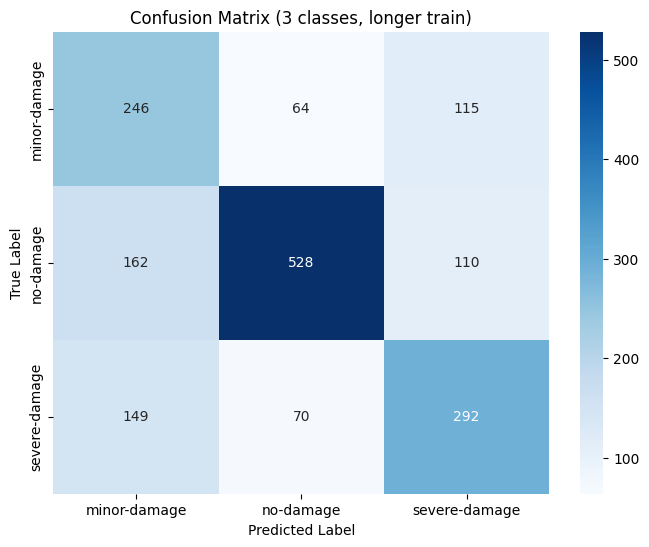

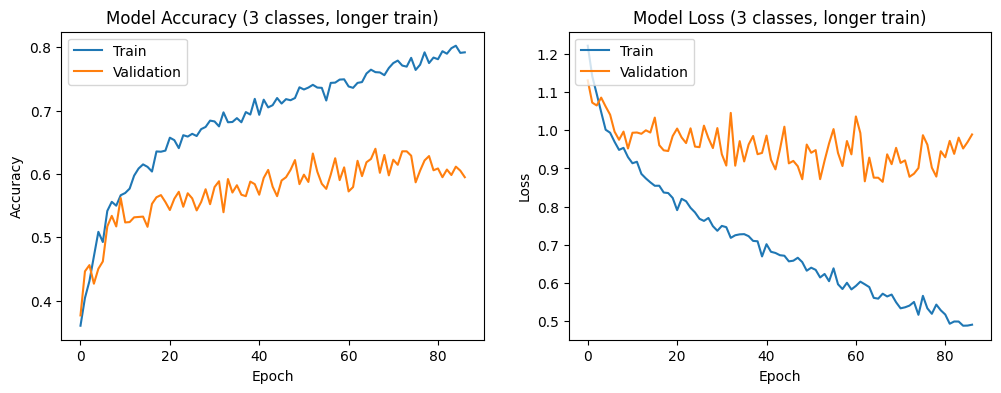

In [19]:
# Imports (same as before)
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data (Adjusted for 3 classes and new directory)
base_dir = '/kaggle/working/xbd_reorganized'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names (3 classes):", class_names)

# Calculate Class Weights (for 3 classes)
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights (3 classes):", class_weights_dict)

# 2. Model Setup - Unfreeze the last 25 layers of ResNet50V2
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = True
for layer in base_model.layers[:-25]: # Unfreeze the last 25 layers
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax') # Output layer with 3 units
])

# 3. Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5), # Using the best learning rate found so far
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20, # Increased patience
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_3class_longer_train.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

# 5. Train the Model
epochs = 200 # Increased number of epochs
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights_dict
)

# 6. Evaluate the Model
model = models.load_model('/kaggle/working/best_model_3class_longer_train.keras')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss (3 classes, longer train): {test_loss:.4f}, Test Accuracy (3 classes, longer train): {test_accuracy:.4f}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("Classification Report (3 classes, longer train):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (3 classes, longer train)')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (3 classes, longer train)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (3 classes, longer train)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Found 2301 images belonging to 3 classes.
Found 1737 images belonging to 3 classes.
Found 1736 images belonging to 3 classes.
Class Names: ['minor-damage', 'no-damage', 'severe-damage']
Class Weights: {0: 1.2411003236245954, 1: 0.690990990990991, 2: 1.3385689354275743}
Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.4009 - loss: 1.3199
Epoch 1: val_accuracy improved from -inf to 0.44560, saving model to /kaggle/working/best_model_3class_refined_aug.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 61s 551ms/step - accuracy: 0.4005 - loss: 1.3191 - val_accuracy: 0.4456 - val_loss: 1.0714
Epoch 2/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4289 - loss: 1.1302
Epoch 2: val_accuracy improved from 0.44560 to 0.48129, saving model to /kaggle/working/best_model_3class_refined_aug.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.4291 - loss: 1.1300 - val_accuracy: 0.4813 - val_loss: 1.0186
Epoch 3/150
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4583 - loss: 1.0626
Epoch 3: val_accuracy improved from 0.48129 to 0.50777, saving model to /kaggle/working/best_model_3class_refined_aug.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 434ms/step - accuracy: 0.4585 - loss: 1.0624 - val_accuracy: 0.5078 - val_loss: 0.9839
Epoch 4/150
72/72 ━━━━━━━━━━

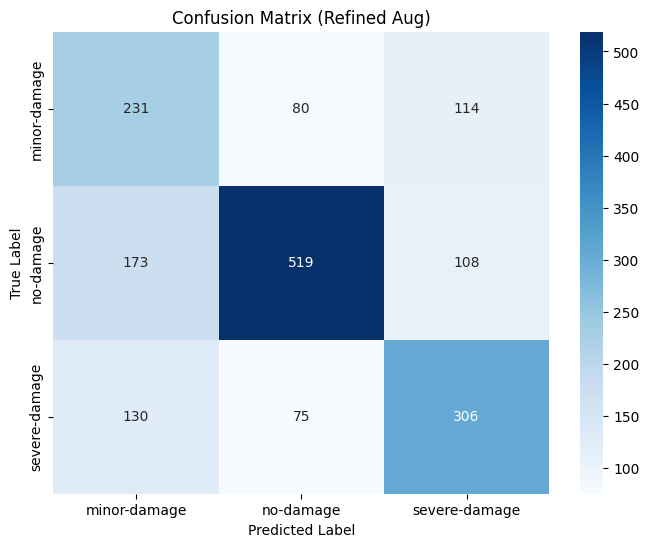

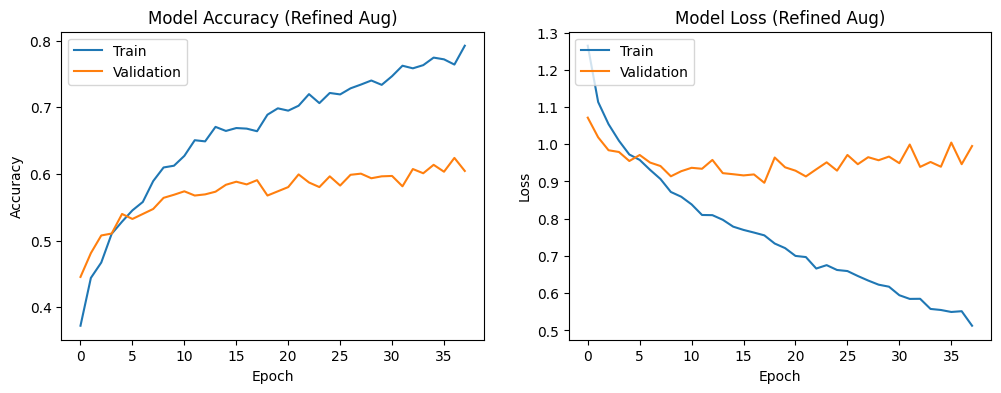

In [23]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight

# 1. Load and Preprocess the Data
base_dir = '/kaggle/working/xbd_reorganized'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation for Training (Refined)
def adjust_contrast(img):
    """Randomly adjusts the contrast of an image."""
    factor = tf.random.uniform(shape=[], minval=0.9, maxval=1.1)
    return tf.image.adjust_contrast(img, factor)

def preprocess_train(img):
    """Applies data augmentation to the training images."""
    img = img / 255.0
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = adjust_contrast(img)
    return img

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    preprocessing_function=preprocess_train,
    fill_mode='nearest'
)

# Only rescaling for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

# Calculate Class Weights
y_train = train_generator.classes
class_labels = np.unique(y_train)
class_weights_computed = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weights_dict = dict(zip(train_generator.class_indices.values(), class_weights_computed))
print("Class Weights:", class_weights_dict)

# 2. Model Setup
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-25]:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_3class_refined_aug.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

# 5. Train the Model
epochs = 150
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    class_weight=class_weights_dict
)

# 6. Evaluate the Model
model = tf.keras.models.load_model('/kaggle/working/best_model_3class_refined_aug.keras')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss (Refined Aug): {test_loss:.4f}, Test Accuracy (Refined Aug): {test_accuracy:.4f}")

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
print("Classification Report (Refined Aug):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
confusion = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Refined Aug)')
plt.show()

# Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (Refined Aug)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (Refined Aug)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
